In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
dtype = np.dtype('float32')
path = "../LOFAR_2e_jaars_RP_2022_voor_studenten/Data_Pulsar1/L197621_SAP0_BEAM1_DM12.44_mask.dat"
#path = "../LOFAR_2e_jaars_RP_2022_voor_studenten/Data_Pulsar1/L197621_SAP0_BEAM1_DM12.44.dat"
with open( path, 'rb') as f:
    pulsar_data = np.fromfile(f, dtype)

mean subtraction (doesn't work yet)

In [3]:
#mean_calculator_interval = 2000
#for i in np.arange(0, len(pulsar_data) - mean_calculator_interval, mean_calculator_interval):
#    final_list= []
#    mean_crop = np.median(pulsar_data[i:i+mean_calculator_interval])
#    zeros1, mean_numbers, zeros2= np.zeros([i]), np.full(mean_calculator_interval, mean_crop), np.zeros([int(len(pulsar_data) - i - mean_calculator_interval)])
#    for zero in zeros1:
#        final_list.append(zero)
#    for mean in mean_numbers:
#        final_list.append(mean)
#    for zero in zeros2:
#        final_list.append(zero)
#    array = np.array(final_list)
#    pulsar_data -= array
    

In [29]:
dt = 0.00262143998406827
nbins = 69120 
total_time = nbins * dt
time = [t*dt for t in np.arange(0, nbins)]

In [30]:
%matplotlib qt
plt.plot(pulsar_data)

# some utility functions

In [6]:
def short_list(lst):
    """
    Returns a string that is a short representation of list lst; useful for long lists.
    """
    if len(lst) >= 4:
        return f"{lst[0]},\t{lst[1]},\t...\t,{lst[-1]},\t{lst[-2]}"
    return lst

In [7]:
def elements_containing_string(search_query, lst):
    """
    This function exists to prevent repeatingly writing the (unreadable) list
    comprehension it returns to find the elements of the list that contain the
    search_query.
    """
    return [x for x in lst if x.lower().find(search_query.strip().lower()) != -1]

In [8]:
def contains_substring(str, sub_str):
    """
    More readable syntax for checking if a string contains a substring.
    """
    return str.lower().find(sub_str.strip().lower()) != -1

In [9]:
def slice_string_at_char(str, char):
    """
    Returns a list of strings splitted on char.
    """
    return str.split(char)

In [10]:
def get_metadata_item(metadata, item):
    return slice_string_at_char(elements_containing_string(item, metadata)[0], '=')[1]

In [11]:
metadata_path = '../LOFAR_2e_jaars_RP_2022_voor_studenten/Data_Pulsar1/L197621_SAP0_BEAM1_DM12.44_Mask.inf'
#metadata_path = '../LOFAR_2e_jaars_RP_2022_voor_studenten/Data_Pulsar1/L197621_SAP0_BEAM1_DM12.44.inf'
with open(metadata_path) as f:
    metadata = f.readlines()

short_list(metadata)

' Data file name without suffix          =  L197621_SAP0_BEAM1_DM12.44_Mask\n,\t Telescope used                         =  LOFAR\n,\t...\t,\n,\t\n'

In [12]:
nbins = int(get_metadata_item(metadata, 'Number of bins in the time series'))
dt = float(get_metadata_item(metadata, 'Width of each time series bin (sec)'))

(0.0, 209.80255598842447)

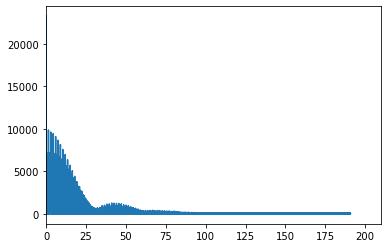

In [13]:
frequencies  = np.fft.fftfreq(nbins, dt)
transform = np.fft.fft(pulsar_data) / len(pulsar_data) # normalize the transform.
plt.clf()
plt.plot(frequencies[1:], abs(transform[1:]))
plt.xlim(0) # to remove the symmetry from the plot.

## Calculation using built-in fftfreq of numpy. 

In [17]:
from scipy.signal import find_peaks
height_threshold = 4700 # Just reading off an apprpriate value from the graph
peaks_index, properties = find_peaks(np.abs(transform), height=height_threshold)

In [18]:
peak_frequencies = [frequencies[i] for i in peaks_index]

In [19]:
# Just change the height threshold above if we want less peaks to be marked.
plt.clf()
plt.plot(frequencies[1:], np.abs(transform[1:]),'-', frequencies[peaks_index],properties['peak_heights'],'x')
plt.xlim(0,25)

(0.0, 25.0)

# automated period finding of pulsar

In [20]:
def find_period(peaks_index, frequencies):
    counter = -1
    list_frequencies_harmonics = []
    for index in peaks_index:
        counter += 1
        if counter ==0:
            freq = frequencies[index]
        else:
            freq = frequencies[index]/counter
        list_frequencies_harmonics.append(freq)
    index = 0
    list_frequencies_harmonics = np.array(list(filter(lambda x: x>0, list_frequencies_harmonics)))
    final_period = np.mean(list_frequencies_harmonics[1:])
    length = len(list_frequencies_harmonics)
    period = final_period ** -1
    return period, list_frequencies_harmonics

## stacking

In [21]:

period, list_frequencies_harmonics = find_period(peaks_index=peaks_index, frequencies=frequencies)
period_in_index = int(period // dt) # TODO: Can we get this int thing away?? i cannot because it needs to be used as index for list
stack_dict = dict()
i = 0
while i <= nbins:
    stack_dict[f"stack{i // period_in_index}"] = np.array( pulsar_data[i:i+period_in_index])
    i += period_in_index

In [24]:
stack = np.zeros(period_in_index) # initializing with zeroes to get the correct stack size.
for key, val in stack_dict.items():
    if ( length := len(val) ) != period_in_index: # This happens at the end.
        print(f'Length of the dictionary element {key} is not {period_in_index}. Did you expect this?')
        stack += np.append(val, np.zeros(period_in_index - length )) # fill with zeroes to keep the same size.
    else:
        stack += val
len(stack) == period_in_index

Length of the dictionary element stack135 is not 510. Did you expect this?


True

In [25]:
plt.plot([ dt * t for t in range(len(stack))], stack, color='magenta')
plt.xlabel('time (s)')
plt.ylabel('intensity')
plt.title('graph of an addition of signals of the first radio pulsar ever found.')

Text(0.5, 1.0, 'graph of an addition of signals of the first radio pulsar ever found.')

In [28]:
for i, val in enumerate ( stack_dict.values() ) :
    offset = i * 0.16 * 10 **6
    plt.plot(stack_dict[f'stack{i}'] + offset, color='black') 

## Data of Hessel's pulsar

This data consists of multiple seperate files, so we have to load them all in with their metadata.

In [22]:
import os
import glob
from pathlib import Path

def import_files(path, dtype):
    '''
    Import files in the syntax that I used in the notebook. That is, choose the path that contains
    all the files, then obtain all dat and inf files as dictionaries that can be accessed by filename. 
    '''

    filename = "*.dat"
    files =  [ p for p in Path(path).glob(filename) ]
    file_dict = dict()
    for file in files:
        with open(file, 'rb') as f:
            # key of the dict is the filename, value the data.
            file_dict[os.path.basename(file)] = np.fromfile(f, np.float32)

    metadata_dict = dict()
    filename = "*.inf"
    files =  [ p for p in Path(path).glob(filename) ]
    for file in files:
        with open(file) as f:
            metadata_dict[os.path.basename(file)] = f.readlines()

    return file_dict, metadata_dict 


In [23]:
data_dict, metadata_dict = import_files(path="../LOFAR_2e_jaars_RP_2022_voor_studenten/Data_Pulsar2", dtype="float32")

In [24]:
print(short_list(data_dict['L83079_SAP0_BEAM0_DM39.66.dat']))
print(short_list(metadata_dict['L83079_SAP0_BEAM0_DM39.66.inf']))

43037.0,	43082.0,	...	,44427.1015625,	44427.1015625
 Data file name without suffix          =  L83079_SAP0_BEAM0_DM39.66
,	 Telescope used                         =  LOFAR
,	...	,
,	



In [25]:
metadata_dict['L83029_SAP0_BEAM0_DM39.66.inf']

[' Data file name without suffix          =  L83029_SAP0_BEAM0_DM39.66\n',
 ' Telescope used                         =  LOFAR\n',
 ' Instrument used                        =  HBA_110_190\n',
 ' Object being observed                  =  J1810+1715\n',
 ' J2000 Right Ascension (hh:mm:ss.ssss)  =  18:10:37.0000\n',
 ' J2000 Declination     (dd:mm:ss.ssss)  =  17:44:37.0000\n',
 ' Data observed by                       =  Unknown\n',
 ' Epoch of observation (MJD)             =  56299.364628335424641\n',
 ' Barycentered?           (1 yes, 0 no)  =  1\n',
 ' Number of bins in the time series      =  8800000    \n',
 ' Width of each time series bin (sec)    =  2.04799998755334e-05\n',
 ' Any breaks in the data? (1 yes, 0 no)  =  1\n',
 ' On/Off bin pair #  1                   =  0          , 8467354    \n',
 ' On/Off bin pair #  2                   =  8799999    , 8799999    \n',
 ' Type of observation (EM band)          =  Radio\n',
 ' Beam diameter (arcsec)                 =  0\n',
 ' Dispe

In [26]:
metadata_dict['L83061_SAP0_BEAM0_DM39.66.inf']

[' Data file name without suffix          =  L83061_SAP0_BEAM0_DM39.66\n',
 ' Telescope used                         =  LOFAR\n',
 ' Instrument used                        =  HBA_110_190\n',
 ' Object being observed                  =  J1810+1715\n',
 ' J2000 Right Ascension (hh:mm:ss.ssss)  =  18:10:37.0000\n',
 ' J2000 Declination     (dd:mm:ss.ssss)  =  17:44:37.0000\n',
 ' Data observed by                       =  Unknown\n',
 ' Epoch of observation (MJD)             =  56299.619493978832907\n',
 ' Barycentered?           (1 yes, 0 no)  =  1\n',
 ' Number of bins in the time series      =  8800000    \n',
 ' Width of each time series bin (sec)    =  2.04799998755334e-05\n',
 ' Any breaks in the data? (1 yes, 0 no)  =  1\n',
 ' On/Off bin pair #  1                   =  0          , 8467346    \n',
 ' On/Off bin pair #  2                   =  8799999    , 8799999    \n',
 ' Type of observation (EM band)          =  Radio\n',
 ' Beam diameter (arcsec)                 =  0\n',
 ' Dispe

In [27]:
nbins_dict = dict()
dt_dict = dict()
for key, val in metadata_dict.items():
    nbins_dict[key] = int(get_metadata_item('Number of bins in the time series'))
    dt_dict[key] = float(get_metadata_item('Width of each time series bin (sec)'))

TypeError: get_metadata_item() missing 1 required positional argument: 'item'

In [ ]:
nbins_dict.values()

dict_values([69120, 69120, 69120, 69120, 69120, 69120, 69120, 69120, 69120, 69120, 69120, 69120, 69120, 69120])

In [ ]:
dt_dict.values()

dict_values([0.00262143998406827, 0.00262143998406827, 0.00262143998406827, 0.00262143998406827, 0.00262143998406827, 0.00262143998406827, 0.00262143998406827, 0.00262143998406827, 0.00262143998406827, 0.00262143998406827, 0.00262143998406827, 0.00262143998406827, 0.00262143998406827, 0.00262143998406827])